In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
#Loading data
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
df = df.drop(columns=["Name"])
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

data = df.values

In [4]:
#Just to get an idea of the shape
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036
2006-01-04,10.73,10.85,10.64,10.71,155225609
2006-01-05,10.69,10.70,10.54,10.63,112396081
2006-01-06,10.75,10.96,10.65,10.90,176139334
2006-01-09,10.96,11.03,10.82,10.86,168861224


In [5]:
#Creating the sequential data for RNN
def create_sequences(data, seq_length, target_col):
    xs = []
    ys = []

    #Using lists to take data indices and returning them as np arrays
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, target_col]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [29]:
#Preprocessing
scalerX = StandardScaler()
scalerY = StandardScaler()

SEQ_LEN = 20 #sequence length

#Split the data
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.2)
target_col = 4 #col dor CLOSED value

X = data[:, :target_col]
y = data[:, target_col]
y = y.reshape(-1, 1)         # scaler expects 2D

trainX = X[:train_size]
testX  = X[train_size:]

trainY = y[:train_size]
testY  = y[train_size:]

#Z score
trainX = scalerX.fit_transform(trainX)
trainY = scalerY.fit_transform(trainY)

testX = scalerX.transform(testX)
testY = scalerY.transform(testY)

#Creating sequential data
trainX, trainY = create_sequences(np.concatenate([trainX, trainY], axis=1), SEQ_LEN, target_col)
testX, testY = create_sequences(np.concatenate([testX, testY], axis=1), SEQ_LEN, target_col)

#And put everything into tensors for torch
trainX = torch.tensor(trainX, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

RNN Model

In [30]:
#RNN model
class RNN(nn.Module): #Class def for network and architecture
  def __init__(self, input_size=5, hidden_size=64, num_layers=1, output_size=1):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x): #Forward pass
    out, _ = self.rnn(x)
    out = self.fc(out[:, -1, :])
    return out

In [31]:
#Create network
RNN_model = RNN()

#Parameters for it
lr = 0.01
num_epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=lr)
lossList = []

#Run the training
for epoch in range(num_epochs):
  RNN_model.train()
  output = RNN_model(trainX)

  loss = criterion(output, trainY.view(-1, 1).float())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  lossList.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3766
Epoch [20/100], Loss: 0.3175
Epoch [30/100], Loss: 0.3022
Epoch [40/100], Loss: 0.2965
Epoch [50/100], Loss: 0.2931
Epoch [60/100], Loss: 0.2902
Epoch [70/100], Loss: 0.2971
Epoch [80/100], Loss: 0.2938
Epoch [90/100], Loss: 0.2880
Epoch [100/100], Loss: 0.2853


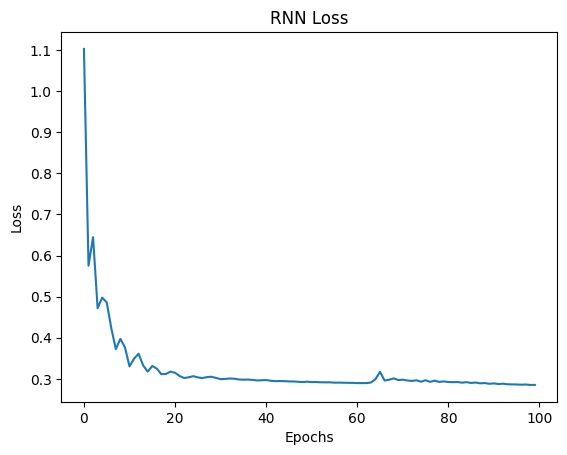

In [32]:
#Plotting the Loss during learning
plt.plot(lossList)
plt.xlabel('Epochs')
plt.ylabel('Loss')
title = 'RNN Loss'
plt.title(title)
plt.show()

In [33]:
#Evaluation of RNN
RNN_model.eval()

#Run test data through network
with torch.no_grad():
  pred = RNN_model(testX).numpy()
  pred = scalerY.inverse_transform(pred)

#Inverse z score
testY = scalerY.inverse_transform(testY.reshape(-1, 1))

#Some metrics
mae = mean_absolute_error(testY, pred)
rmse = np.sqrt(mean_squared_error(testY, pred))
r2 = r2_score(testY, pred)
mape = np.mean(np.abs((testY - pred) / testY)) * 100

#And printing them
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)
print("MAPE:", mape)

MAE : 11030832.50923507
RMSE: 14362750.936835224
R²  : 0.19588988533876883
MAPE: 34.340476626665215


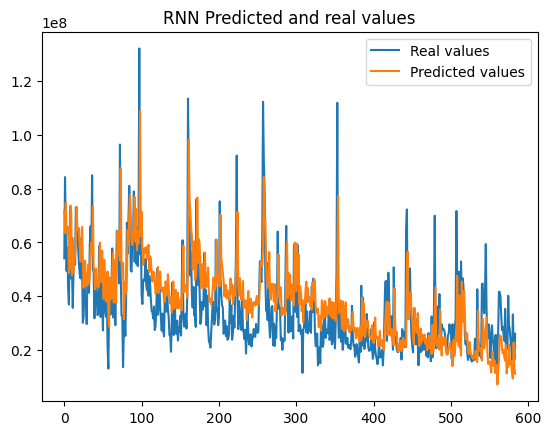

In [34]:
#Plotting Real and predicted for better visual
plt.plot(testY, label='True')
plt.plot(pred, label='Predicted')
plt.legend(["Real values", "Predicted values"])
plt.title("RNN Predicted and real values")
plt.show()

LSTM 1 step rolling version

In [12]:
#Preprocessing again. Same idea but we need to use different scaler for LSTM so
#it is just easier to run whole process again from the top

scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

SEQ_LEN = 50 #Longer sequence for learning patterns better

#Split
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.2)
target_col = 4

X = data[:, :target_col]
y = data[:, target_col]
y = y.reshape(-1, 1)         # scaler expects 2D

trainX = X[:train_size]
testX  = X[train_size:]

trainY = y[:train_size]
testY  = y[train_size:]

#MinMax
trainX = scalerX.fit_transform(trainX)
trainY = scalerY.fit_transform(trainY)

testX = scalerX.transform(testX)
testY = scalerY.transform(testY)

#Sequential data
trainX, trainY = create_sequences(np.concatenate([trainX, trainY], axis=1), SEQ_LEN, target_col)
testX, testY = create_sequences(np.concatenate([testX, testY], axis=1), SEQ_LEN, target_col)

#and tensors
trainX = torch.tensor(trainX, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

In [13]:
class LSTM(nn.Module): #LSTM definition
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x): #Forward pass
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

In [14]:
#Paramters for LSTM network
num_epochs = 20
lr = 0.001
batch_size = 32
LSTMlossList = []

#LSTM model creation
LSTM_model = LSTM(input_size=trainX.shape[2], hidden_size=128, num_layers=3, output_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=lr)

#Training
for epoch in range(num_epochs):
  LSTM_model.train()

  for i in range(0, len(trainX), batch_size):
    batchX = trainX[i:i+batch_size]
    batchY = trainY[i:i+batch_size].view(-1, 1)

    optimizer.zero_grad()

    pred = LSTM_model(batchX)
    loss = criterion(pred, batchY)

    loss.backward()
    optimizer.step()

    LSTMlossList.append(loss.item())

  if (epoch + 1) % 5 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/20], Loss: 0.0009
Epoch [20/20], Loss: 0.0008


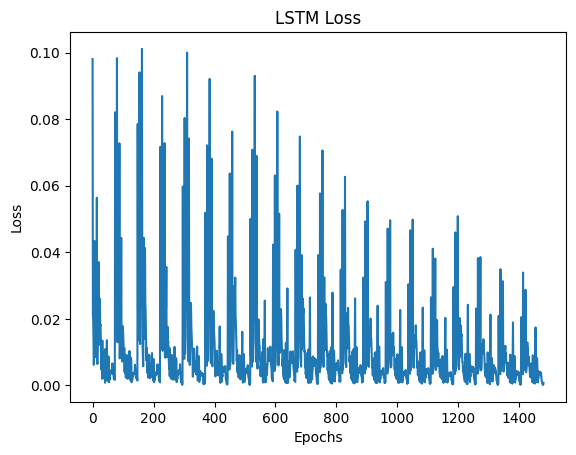

In [35]:
plt.plot(LSTMlossList)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Loss in training')
plt.show()

In [16]:
#Evaluation
predictions = []

LSTM_model.eval()
last_seq = testX[0].unsqueeze(0)

with torch.no_grad():
  for i in range(len(testX)):
    pred_scaled = LSTM_model(last_seq)
    pred = scalerY.inverse_transform(pred_scaled.numpy())
    predictions.append(pred[0,0])

    #Diagnostics print for helping later
    #last_window_values = last_seq[0, -1, :].numpy()
    #print(f"Step {i+1}: Last window input = {last_window_values}, Predicted = {pred[0,0]}")

    new_input = testX[i].unsqueeze(0).clone()  #take actual features
    new_input[:, target_col] = pred_scaled     #insert predicted target
    last_seq = torch.cat((last_seq[:,1:,:], new_input), dim=1) #and combie to new seq


In [17]:
#Metrics
pred = np.array(predictions).reshape(-1, 1)
testY = scalerY.inverse_transform(testY.reshape(-1, 1))
LSTM_mae = mean_absolute_error(testY, pred)
LSTM_rmse = np.sqrt(mean_squared_error(testY, pred))
LSTM_r2 = r2_score(testY, pred)
LSTM_mape = np.mean(np.abs((testY - pred) / testY)) * 100

#Printing
print("MAE :", LSTM_mae)
print("RMSE:", LSTM_rmse)
print("R²  :", LSTM_r2)
print("MAPE:", LSTM_mape)

MAE : 15765411.542640666
RMSE: 19369936.820732694
R²  : -0.5355926449185309
MAPE: 51.580223106523825


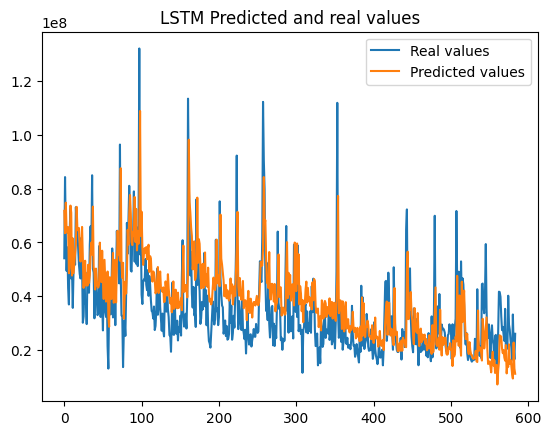

In [36]:
plt.plot(testY, label='True')
plt.plot(pred, label='Predicted')
plt.legend(["Real values", "Predicted values"])
plt.title("LSTM Predicted and real values")
plt.show()

LSTM Multi step version

In [19]:
#For multistep version we need to take into account how many steps forward we want to go
def create_multi_sequences(data, seq_len, horizon, target_col):
    xs = []
    ys = []

    #Otherwise same idea than before
    for i in range(len(data) - seq_len - horizon):
        x = data[i : i + seq_len]                                   # (seq_len, features)
        y = data[i + seq_len : i + seq_len + horizon, target_col]   # (horizon,)
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


In [20]:
#Preprocessing
#Once again easier to just run entire thing again
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

SEQ_LEN = 50
HORIZON = 10 #How many steps forward

#Split
train_size = int(len(data)*0.8)
test_size = int(len(data)*0.2)
target_col = 4

X = data[:, :target_col]
y = data[:, target_col]
y = y.reshape(-1, 1)         # scaler expects 2D

trainX = X[:train_size]
testX  = X[train_size:]

trainY = y[:train_size]
testY  = y[train_size:]

#Scale
trainX = scalerX.fit_transform(trainX)
trainY = scalerY.fit_transform(trainY)

testX = scalerX.transform(testX)
testY = scalerY.transform(testY)

#Sequential data for multistep version
trainX, trainY = create_multi_sequences(np.concatenate([trainX, trainY], axis=1), SEQ_LEN, HORIZON, target_col)
testX, testY = create_multi_sequences(np.concatenate([testX, testY], axis=1), SEQ_LEN, HORIZON, target_col)

#Tensors
trainX = torch.tensor(trainX, dtype=torch.float32)
testX = torch.tensor(testX, dtype=torch.float32)
trainY = torch.tensor(trainY, dtype=torch.float32)
testY = torch.tensor(testY, dtype=torch.float32)

In [21]:
class LSTM_multi(nn.Module): #New LSTM def, only thing that really changes is output
    def __init__(self, input_size, hidden_size, num_layers, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]       # last timestep
        out = self.fc(out)        # output full forecast horizon
        return out


In [22]:
#Params
epochs = 10
lr = 0.001
batch_size = 32

#Create model
model = LSTM_multi(input_size=trainX.shape[2], hidden_size=128, num_layers=3, horizon=HORIZON)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [23]:
#Training
for ep in range(epochs):
    model.train()

    LSTMlossListMulti = []

    #Running this batch by batch
    for i in range(0, len(trainX), batch_size):
        batchX = trainX[i:i+batch_size]
        batchY = trainY[i:i+batch_size]

        optimizer.zero_grad()
        pred = model(batchX)
        loss = criterion(pred, batchY)
        loss.backward()
        optimizer.step()

        LSTMlossListMulti.append(loss.item())

    print(f"Epoch {ep+1}/{epochs}, Loss = {loss:.4f}")


Epoch 1/10, Loss = 0.0011
Epoch 2/10, Loss = 0.0017
Epoch 3/10, Loss = 0.0025
Epoch 4/10, Loss = 0.0021
Epoch 5/10, Loss = 0.0012
Epoch 6/10, Loss = 0.0033
Epoch 7/10, Loss = 0.0014
Epoch 8/10, Loss = 0.0008
Epoch 9/10, Loss = 0.0025
Epoch 10/10, Loss = 0.0009


In [24]:
#Evaluation
model.eval()
with torch.no_grad():
    preds_scaled = model(testX).numpy()   # (samples, horizon)

#Init some np arrays
pred = np.zeros_like(preds_scaled)
actual = np.zeros_like(testY.numpy())

#Taking the results and undoing things we did to them
for h in range(HORIZON):
    pred[:, h] = scalerY.inverse_transform(preds_scaled[:, h].reshape(-1,1)).reshape(-1)
    actual[:, h] = scalerY.inverse_transform(testY[:, h].reshape(-1,1)).reshape(-1)


(544, 10)


In [25]:
#Metrics
LSTM_mae  = mean_absolute_error(actual, pred)
LSTM_rmse = np.sqrt(mean_squared_error(actual, pred))
LSTM_r2   = r2_score(actual, pred)
LSTM_mape = np.mean(np.abs((actual - pred) / actual)) * 100

#And printing
print("MAE :", LSTM_mae)
print("RMSE:", LSTM_rmse)
print("R²  :", LSTM_r2)
print("MAPE:", LSTM_mape)

MAE : 24708762.0
RMSE: 27989423.112181216
R²  : -2.2237915992736816
MAPE: 90.08362


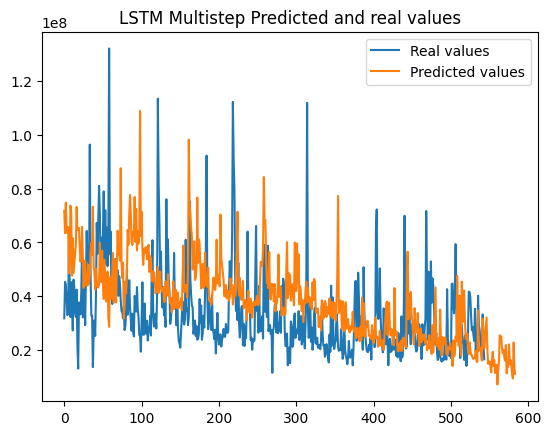

In [37]:
#Ploting results
plt.plot(actual[:, -1], label='True')
plt.plot(pred[:, -1], label='Predicted')
plt.legend(["Real values", "Predicted values"])
plt.title("LSTM Multistep Predicted and real values")
plt.show()